In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd

In [24]:
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18dd02a95f8>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [11]:
first_row = session.query(station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x18dd031f1d0>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#query = session.query(measurement.date, measurement.prcp).filter(measurement.date > query_date).order_by(measurement.date).all()

# Calculate the date 1 year ago from the last data point in the database
latest = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f'The latest date in the database is {latest}.')
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f'The query date is {query_date}.')
# I spent several hours trying to figure out a way to not have to put the numbers in the query_date formula and could not
# figure it out

The latest date in the database is ('2017-08-23',).
The query date is 2016-08-23.


In [13]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).\
    filter(measurement.prcp > 0).all()
#    
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_query, columns=['Date','precipitation'])
df.set_index('Date',inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)
df.head(10)

,precipitation
Date,
2016-08-23,1.79
2016-08-23,0.70
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.15
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,2.28


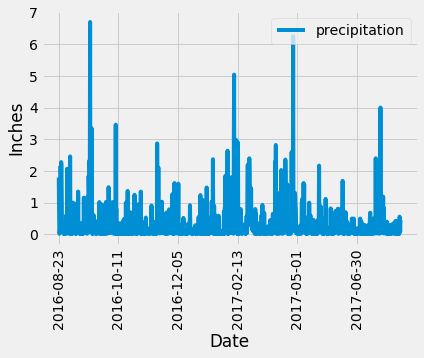

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)
plt.xticks(rotation=90)
plt.legend(loc="upper right")
plt.ylabel('Inches')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurement.station).count()
uniq_stat = session.query(measurement.station).\
            distinct(measurement.station).\
            group_by(measurement.station).count()
# or session.query(station.station).count()
print(f'There are {station_count} instances of stations in this dataset with {uniq_stat} unique stations.')

There are 19550 instances of stations in this dataset with 9 unique stations.


In [17]:
active_stations = session.query(measurement.station).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).count()
active_stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).all()
for row in active_stations:
    print(f'Station {row[0]} has {row[1]} observations.')

most = session.query(measurement.station, func.count(measurement.station)).\
                    group_by(measurement.station).\
                    order_by(func.count(measurement.station).desc()).first()
print(f'------------------------------------------------------')    
print(f'Station {most.station} has the most observations at {most[1]}.')

Station USC00519281 has 2772 observations.
Station USC00519397 has 2724 observations.
Station USC00513117 has 2709 observations.
Station USC00519523 has 2669 observations.
Station USC00516128 has 2612 observations.
Station USC00514830 has 2202 observations.
Station USC00511918 has 1979 observations.
Station USC00517948 has 1372 observations.
Station USC00518838 has 511 observations.
------------------------------------------------------
Station USC00519281 has the most observations at 2772.


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]
high_stat = session.query(*sel).filter_by(station = 'USC00519281').all()
print(f'Station USC00519281')
print(f'Lowest Temp Recorded: {high_stat[0][0]},')
print(f'Highest Temp Recorded: {high_stat[0][1]},')
print(f'Average Temp Recorded:{round(high_stat[0][2],1)}.')

Station USC00519281
Lowest Temp Recorded: 54.0,
Highest Temp Recorded: 85.0,
Average Temp Recorded:71.7.


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temps = session.query(measurement.tobs).filter(measurement.station == 'USC00519281').\
filter(measurement.date >= query_date).all()
hist_df = pd.DataFrame(most_temps, columns=['tobs'])
hist_df.sort_values(by='tobs',inplace=True)
hist_df.head(10)

,tobs
163,59.0
169,59.0
170,59.0
250,60.0
164,60.0
186,61.0
196,62.0
171,62.0
114,62.0
136,62.0


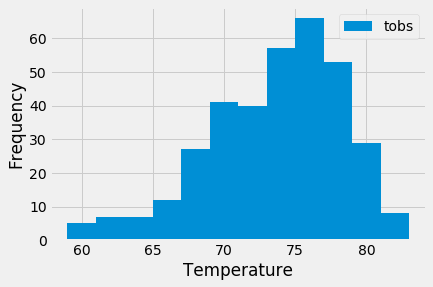

In [21]:
hist_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
